In [16]:
# Gerekli kütüphanelerin içe aktarılması
import yfinance as yf  # Finansal veri indirmek için
import numpy as np  # Sayısal işlemler için
from sklearn.preprocessing import MinMaxScaler  # Veri ölçeklendirmek için
from tensorflow.keras.models import Sequential  # Model oluşturmak için
from tensorflow.keras.layers import LSTM, Dense, Dropout , Activation, BatchNormalization # Model katmanları
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau # Model eğitimini durdurmak için
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import mean_squared_error  , mean_absolute_error , r2_score  # Hata ölçümü için
import mplfinance as mpf  # Finansal verileri görselleştirmek için
import pandas as pd  # Veri işleme için
import plotly.graph_objects as go

In [17]:
# Veri Toplama
btc_data = yf.download('BTC-USD', period='3600d')  # Bitcoin verilerini yfinance ile indirme
#btc_data

[*********************100%%**********************]  1 of 1 completed


In [18]:
# İndirilen Verileri Mum Çubukları ile Görselleştirme
#mpf.plot(btc_data, type='candle', volume=True, style='yahoo', title='BTC-USD') 

In [19]:
# Veri Hazırlama
btc_df = btc_data[['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume']]  # İlgili sütunların seçilmesi


In [20]:
#zero base normalization
btc_df['Open'] = btc_df['Open'] / btc_df['Open'].iloc[0] - 1

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Ölçekleyici tanımlama
scaled_data = scaler.fit_transform(btc_df)  # Verilerin ölçeklendirilmesi


In [22]:

# Zaman serisi veri seti oluşturma fonksiyonu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:]  # Girdi verileri
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0:])  # Çıktı verileri
    return np.array(dataX), np.array(dataY)

time_step = 7  # Zaman adımı
X, y = create_dataset(scaled_data, time_step)  # X ve y veri setlerinin oluşturulması




In [23]:
# Veri setini eğitim ve test setlerine ayırma
test_size = 300  # Test setinin boyutu
train_size = int(len(X) - test_size)  # Eğitim setinin boyutu
X_train, X_test = X[0:train_size,:,:], X[train_size:len(X),:,:]  # Eğitim ve test girdileri
y_train, y_test = y[0:train_size,:], y[train_size:len(y),:]  # Eğitim ve test çıktıları


In [24]:
units1 = 2000  # İlk LSTM katmanı için birim sayısı
units2 = units1*2  # İkinci LSTM katmanı için birim sayısı
units3 = units1  # Yoğun katmanlar için birim sayısı
units3 = units1/2  # Yoğun katmanlar için birim sayısı
units4 = units3/2  # Yoğun katmanlar için birim sayısı
units5 = units4/2  # Yoğun katmanlar için birim sayısı


dropout = 0.2  # Dropout oranı
batch_size = X_train.shape[0] / 1 # Batch boyutu
batch_size = int(batch_size)
activation = 'relu'  # Aktivasyon fonksiyonu
epochs = 50  # Eğitim sayısı

In [25]:
input_shape=(X_train.shape[1], 6)
input_shape

(7, 6)

In [26]:
# LSTM Model Oluşturma

model = Sequential([
    LSTM(units=units1, return_sequences=True, input_shape=(X_train.shape[1], 6),
         dropout=0.1, recurrent_dropout=0.1),  # İlk LSTM katmanı
    BatchNormalization(),
    
    LSTM(units=units2, return_sequences=False, dropout=0.1, recurrent_dropout=0.1),  # İkinci LSTM katmanı
    BatchNormalization(),
    
    Dense(units=units3, activation='relu', kernel_regularizer=l2(0.01)),  # Yoğun katman
    Dropout(0.2),  # Dropout katmanı
    
    Dense(units=units3, activation='relu', kernel_regularizer=l2(0.01)),  # Başka bir yoğun katman
    Dropout(0.2),  # Dropout katmanı
    
    Dense(units=units4, activation='relu', kernel_regularizer=l2(0.01)),  # Başka bir yoğun katman
    Dropout(0.2),  # Dropout katmanı
    

    Dense(units=units5, activation='relu', kernel_regularizer=l2(0.01)),  # Başka bir yoğun katman
    Dropout(0.2),  # Dropout katmanı
    


    Dense(units=6)  # Çıktı katmanı
])
model.summary()  # Model özeti

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 2000)           16056000  
                                                                 
 batch_normalization_2 (Bat  (None, 7, 2000)           8000      
 chNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 4000)              96016000  
                                                                 
 batch_normalization_3 (Bat  (None, 4000)              16000     
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 1000)              4001000   
                                                                 
 dropout_4 (Dropout)         (None, 1000)             

In [27]:
#tensorflow gpu var mı yok mu kontrolü
import tensorflow as tf
tf.test.gpu_device_name()


''

In [28]:
model.compile(optimizer='adam', 
              loss='mean_absolute_error', 
             )  # Modeli derleme

In [29]:
early_stopping = EarlyStopping(monitor='val_loss',  # İzlenecek metrik
                               patience=5,          # Metrikte iyileşme olmadığı durumda kaç epoch bekleyeceği
                               verbose=1,           # Eğitim durdurulduğunda bilgi vermesi
                               restore_best_weights=True)  # En iyi ağırlıkları geri yükleme
# ReduceLROnPlateau callback'ini ayarlama
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # Öğrenme oranını ne kadar azaltacağı
                              patience=3,  # Kaç epoch boyunca iyileşme olmadığında öğrenme oranını azaltacağı
                              min_lr=0.001,  # Öğrenme oranının düşebileceği minimum değer
                              verbose=1)

In [30]:

# Modeli Eğitme ve Tahmin Yapma
history = model.fit(X_train, y_train, 
                    validation_data=(X_test,y_test) , 
                    epochs=epochs, batch_size= batch_size, 
                    verbose=1,  
                    callbacks=[early_stopping , reduce_lr])  # Model eğitimi


Epoch 1/50


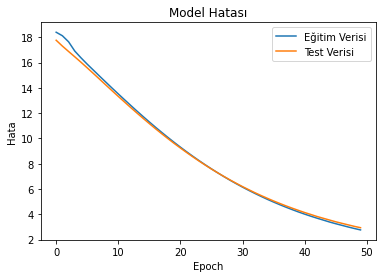

In [ ]:
# Modelin Eğitim ve Test Hata Grafiği
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Eğitim Verisi')
plt.plot(history.history['val_loss'], label='Test Verisi')
plt.title('Model Hatası')
plt.ylabel('Hata')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)  # Test verileri ile modelin performansını ölçme
# bu ne  ? yüksek çıkması iyi mi kötü mü ?


300/300 [==============================] - 2s 8ms/sample - loss: 2.9403


2.9402587445576986

In [ ]:
predictions = model.predict(X_test).squeeze() # Test verisi üzerinde tahmin yapma
#predictions = scaler.inverse_transform(predictions)  # Tahminlerin ölçeklendirilmesinin tersine çevrilmesi


In [ ]:
# Sonuçların Değerlendirilmesi
#predictions = scaler.inverse_transform(predictions)  # Tahminlerin ölçeklendirilmesinin tersine çevrilmesi
#y_test_scaled = scaler.inverse_transform(y_test)  # Gerçek test verilerinin ölçeklendirilmesinin tersine çevrilmesi


MSE = mean_squared_error( predictions , y_test)  # Hata ölçümü
MAE = mean_absolute_error( predictions ,y_test)  # Hata ölçümü
R2 = r2_score(predictions ,y_test)  # Hata ölçümü
print('MSE: ', MSE)
print('MAE: ', MAE)
print('R2: ', R2)


MSE:  0.12424330546092588
MAE:  0.32254531828876715
R2:  -790.2965145158715


In [ ]:
predictions = scaler.inverse_transform(predictions)  # Tahminlerin ölçeklendirilmesinin tersine çevrilmesi


In [ ]:
# Tahmin Edilen Verileri Mum Çubukları ile Görselleştirme
predicted_df = pd.DataFrame(predictions, columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])  # Tahminlerin DataFrame'e dönüştürülmesi
predicted_df['Date'] = pd.date_range(start=btc_data.index[-len(predictions)], periods=len(predictions), freq='D')  # Tarih sütununun eklenmesi
predicted_df.set_index('Date', inplace=True)  # Tarihin indeks olarak ayarlanması


In [ ]:
#mpf.plot(predicted_df, type='candle', volume=True, style='yahoo', title='BTC-USD')  # Gerçek verilerin görselleştirilmesi

In [ ]:
def prepare_data_for_forecasting(latest_data, time_step):
    # Son kullanılabilir verileri al ve ölçeklendir
    last_scaled_data = scaler.transform(latest_data)

    # Son verileri model girdisi olarak hazırla
    X = []
    for i in range(len(last_scaled_data) - time_step):
        X.append(last_scaled_data[i:i + time_step, 0:])

    return np.array(X)


In [ ]:
def predict_future_prices(model, prepared_data, days_to_predict):
    predictions = []

    # Son verileri kullanarak gelecek günler için tahmin yap
    current_batch = prepared_data[-1].reshape(1, prepared_data.shape[1], 6)

    for i in range(days_to_predict):
        # Tahmin yap ve sonucu sakla
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
        
        # Sonraki tahmin için girdiyi güncelle
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    return scaler.inverse_transform(predictions)


In [ ]:
#btc_data = yf.download('BTC-USD', period='6000d')  # Bitcoin verilerini yfinance ile indirme


In [ ]:
days_to_predict = 7  # Kaç gün sonrası için tahmin yapılacağı

btc_data_son_x = btc_data[-days_to_predict:]


#btc_datadan son 30 günü sil (göz ile test için)
btc_data = btc_data[:-days_to_predict]


# Son kullanılabilir verileri al (örneğin son 100 gün)
latest_data = btc_data

# Verileri hazırla
prepared_data = prepare_data_for_forecasting(latest_data, time_step=time_step) # Son 100 gündeki verileri kullanarak gelecek 30 gün için tahmin yap

# Gelecek 30 gün için tahmin yap
future_predictions = predict_future_prices(model, prepared_data, days_to_predict=days_to_predict) # Son 100 gündeki verileri kullanarak gelecek 30 gün için tahmin yapar



In [ ]:
# Tahmin edilen verileri df yap
future_predictions_df = pd.DataFrame(future_predictions, columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])

#btc_datanın son tarihinden başlayarak 30 gün boyunca tarihleri oluştur
future_predictions_df['Date'] = pd.date_range(start=btc_data.index[-1], periods=len(future_predictions_df), freq='D')

# Tarihi indeks olarak ayarla
future_predictions_df.set_index('Date', inplace=True)
future_predictions_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-19,25.371063,12228.401111,11658.969913,11791.732669,11543.457598,1.235339e+10
2023-12-20,25.471977,12269.907228,11722.320405,11840.958099,11581.305779,1.238557e+10
2023-12-21,25.259839,12151.715401,11634.419007,11751.041682,11476.402121,1.235333e+10
2023-12-22,24.836030,11930.992216,11452.852411,11569.525858,11283.399594,1.220428e+10
2023-12-23,24.169527,11587.710667,11153.715945,11263.972916,10967.201443,1.194133e+10
2023-12-24,22.935720,10959.279840,10586.654549,10681.636510,10370.886986,1.148313e+10
2023-12-25,19.948205,9400.288158,9177.319695,9212.265303,8898.252227,1.057361e+10


In [ ]:
btc_data_son_x

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-20,42261.300781,44275.585938,42223.816406,43652.250000,43652.250000,27868908174
2023-12-21,43648.125000,44240.667969,43330.050781,43869.152344,43869.152344,22452766169
2023-12-22,43868.988281,44367.957031,43441.968750,43997.902344,43997.902344,21028503216
2023-12-23,44012.199219,44015.699219,43351.355469,43739.542969,43739.542969,13507796558
2023-12-24,43728.367188,43945.523438,42786.917969,43016.117188,43016.117188,18830554085
2023-12-25,43010.574219,43765.093750,42765.769531,43613.140625,43613.140625,21115795370
2023-12-26,43599.847656,43599.847656,42379.105469,42682.500000,42682.500000,27023734784
